# GAN Model Training: Monet-Style Image Generation

In this notebook, we'll train the CycleGAN model that we designed in the previous notebook (03a_Model_Architecture_Design.ipynb). We'll load the pre-defined models, set up the training process, and generate Monet-style images from photographs.

## 1. Setup and Imports

First, let's import the necessary libraries and set up our environment.

In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import time
import glob
import random
from PIL import Image
from tqdm.notebook import tqdm

# Set plot style - using a style compatible with newer matplotlib versions
plt.style.use('default')

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)

Num GPUs Available:  0
TensorFlow version: 2.16.2


## 2. Load Data

Let's load the datasets for training. This code is similar to what we used in the previous notebook.

In [3]:
# Define paths to the dataset
# Check if we're in Kaggle environment
IN_KAGGLE = os.path.exists('/kaggle/input')

if IN_KAGGLE:
    # Kaggle paths
    MONET_JPG_DIR = "/kaggle/input/gan-getting-started/monet_jpg"
    PHOTO_JPG_DIR = "/kaggle/input/gan-getting-started/photo_jpg"
else:
    # Local paths - adjust these based on your data location
    BASE_DIR = '../data'
    MONET_JPG_DIR = os.path.join(BASE_DIR, 'monet_jpg')
    PHOTO_JPG_DIR = os.path.join(BASE_DIR, 'photo_jpg')
    MONET_TFREC_DIR = os.path.join(BASE_DIR, 'monet_tfrec')
    PHOTO_TFREC_DIR = os.path.join(BASE_DIR, 'photo_tfrec')

# Check if the paths exist
print(f"Monet JPG directory exists: {os.path.exists(MONET_JPG_DIR)}")
print(f"Photo JPG directory exists: {os.path.exists(PHOTO_JPG_DIR)}")
print(f"Monet TFRecord directory exists: {os.path.exists(MONET_TFREC_DIR)}")
print(f"Photo TFRecord directory exists: {os.path.exists(PHOTO_TFREC_DIR)}")

Monet JPG directory exists: True
Photo JPG directory exists: True
Monet TFRecord directory exists: True
Photo TFRecord directory exists: True


In [4]:
# Function for loading from JPG files directly
def load_jpg_dataset(dir_path, shuffle=True, batch_size=1):
    """Load a dataset from JPG files."""
    image_paths = [os.path.join(dir_path, fname) for fname in os.listdir(dir_path) if fname.endswith('.jpg')]
    
    def load_and_preprocess_image(path):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [256, 256])
        img = tf.cast(img, tf.float32)
        img = (img / 127.5) - 1  # Normalize to [-1, 1]
        return img
    
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths))
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset, len(image_paths)

In [5]:
# Function for loading from TFRecord files
def decode_image(image):
    """Decode image from TFRecord format."""
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    image = tf.reshape(image, [256, 256, 3])
    return image

def read_tfrecord(example):
    """Read TFRecord example."""
    tfrecord_format = {
        'image': tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_tfrecord_dataset(filenames, shuffle=True, batch_size=1):
    """Load a dataset from TFRecord files."""
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [6]:
# Load datasets from all available sources
datasets = {}
counts = {}

# Try loading JPG datasets
try:
    if os.path.exists(MONET_JPG_DIR):
        datasets['monet_jpg'], counts['monet_jpg'] = load_jpg_dataset(MONET_JPG_DIR, batch_size=1)
        print(f"Loaded {counts['monet_jpg']} Monet paintings from JPG files")
    
    if os.path.exists(PHOTO_JPG_DIR):
        datasets['photo_jpg'], counts['photo_jpg'] = load_jpg_dataset(PHOTO_JPG_DIR, batch_size=1)
        print(f"Loaded {counts['photo_jpg']} photographs from JPG files")
except Exception as e:
    print(f"Error loading JPG datasets: {e}")

# Try loading TFRecord datasets
try:
    if os.path.exists(MONET_TFREC_DIR):
        monet_tfrecords = tf.io.gfile.glob(os.path.join(MONET_TFREC_DIR, '*.tfrec'))
        if monet_tfrecords:
            datasets['monet_tfrec'] = load_tfrecord_dataset(monet_tfrecords, batch_size=1)
            print(f"Loaded Monet paintings from TFRecord files")
    
    if os.path.exists(PHOTO_TFREC_DIR):
        photo_tfrecords = tf.io.gfile.glob(os.path.join(PHOTO_TFREC_DIR, '*.tfrec'))
        if photo_tfrecords:
            datasets['photo_tfrec'] = load_tfrecord_dataset(photo_tfrecords, batch_size=1)
            print(f"Loaded photographs from TFRecord files")
except Exception as e:
    print(f"Error loading TFRecord datasets: {e}")

# Choose which datasets to use for training
# Prefer TFRecord datasets if available, otherwise use JPG datasets
monet_dataset = datasets.get('monet_tfrec', datasets.get('monet_jpg'))
photo_dataset = datasets.get('photo_tfrec', datasets.get('photo_jpg'))

if monet_dataset is not None and photo_dataset is not None:
    print("Datasets loaded successfully and ready for training")
else:
    print("Error: Could not load required datasets")

Loaded 300 Monet paintings from JPG files
Loaded 7038 photographs from JPG files
Loaded Monet paintings from TFRecord files
Loaded photographs from TFRecord files
Datasets loaded successfully and ready for training


## 3. Load Pre-trained Models

Now, let's load the models that we defined and saved in the previous notebook.

In [7]:
# Define the path to the saved models
models_dir = '../models'

# Check if the models exist
if not os.path.exists(os.path.join(models_dir, 'generator_g.keras')):
    print("Models not found. Please run the 03a_Model_Architecture_Design.ipynb notebook first.")
else:
    # Load the models
    generator_g = tf.keras.models.load_model(os.path.join(models_dir, 'generator_g.keras'))
    generator_f = tf.keras.models.load_model(os.path.join(models_dir, 'generator_f.keras'))
    discriminator_x = tf.keras.models.load_model(os.path.join(models_dir, 'discriminator_x.keras'))
    discriminator_y = tf.keras.models.load_model(os.path.join(models_dir, 'discriminator_y.keras'))
    
    print("Models loaded successfully.")

Models loaded successfully.


## 4. Define Loss Functions

Let's define the loss functions needed for training the CycleGAN model.

In [8]:
# Define loss functions
def discriminator_loss(real, generated):
    """Discriminator loss function."""
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
    
    total_loss = real_loss + generated_loss
    return tf.reduce_mean(total_loss) * 0.5

def generator_loss(generated):
    """Generator adversarial loss function."""
    return tf.reduce_mean(tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated))

def calc_cycle_loss(real_image, cycled_image, LAMBDA=10):
    """Cycle consistency loss function."""
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss

def identity_loss(real_image, same_image, LAMBDA=5):
    """Identity loss function."""
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

## 5. Training Setup

Now, let's set up the training process for our CycleGAN model.

In [9]:
# Define optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [10]:
# Define the training step function
def train_step(real_x, real_y):
    """Training step for CycleGAN."""
    # Use gradient tape for automatic differentiation
    with tf.GradientTape(persistent=True) as tape:
        # Generate fake images
        fake_y = generator_g(real_x, training=True)
        fake_x = generator_f(real_y, training=True)
        
        # Cycle consistency
        cycled_x = generator_f(fake_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
        
        # Identity mapping
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)
        
        # Discriminator outputs
        disc_real_x = discriminator_x(real_x, training=True)
        disc_fake_x = discriminator_x(fake_x, training=True)
        
        disc_real_y = discriminator_y(real_y, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)
        
        # Calculate losses
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        
        # Cycle consistency losses
        cycle_loss_x = calc_cycle_loss(real_x, cycled_x)
        cycle_loss_y = calc_cycle_loss(real_y, cycled_y)
        total_cycle_loss = cycle_loss_x + cycle_loss_y
        
        # Identity losses
        id_loss_x = identity_loss(real_x, same_x)
        id_loss_y = identity_loss(real_y, same_y)
        total_id_loss = id_loss_x + id_loss_y
        
        # Total generator losses
        total_gen_g_loss = gen_g_loss + total_cycle_loss + total_id_loss
        total_gen_f_loss = gen_f_loss + total_cycle_loss + total_id_loss
        
        # Discriminator losses
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
    
    # Calculate gradients
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)
    
    # Apply gradients
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

## 6. Training the Model

Now, let's train our CycleGAN model. We'll train for several epochs and save the model checkpoints.

In [11]:
# Set up checkpoint directory
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_g=generator_g,
    generator_f=generator_f,
    discriminator_x=discriminator_x,
    discriminator_y=discriminator_y,
    generator_g_optimizer=generator_g_optimizer,
    generator_f_optimizer=generator_f_optimizer,
    discriminator_x_optimizer=discriminator_x_optimizer,
    discriminator_y_optimizer=discriminator_y_optimizer
)

# Create checkpoint directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

In [12]:
def generate_images(model, test_input):
    """Generate images using the generator model."""
    prediction = model(test_input)
    
    plt.figure(figsize=(12, 6))
    
    display_list = [test_input[0], prediction[0]]
    title = ['Input Photo', 'Generated Monet-style Image']
    
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [13]:
# Define the training loop
def train(monet_dataset, photo_dataset, epochs=10):
    """Train the CycleGAN model for the specified number of epochs."""
    for epoch in range(epochs):
        start = time.time()
        
        # Reset metrics for each epoch
        n = 0
        
        # Use tqdm for a progress bar
        print(f"Epoch {epoch + 1}/{epochs}")
        
        # Prepare datasets
        monet_iter = iter(monet_dataset)
        photo_iter = iter(photo_dataset)
        
        # Determine the number of batches (use the smaller dataset)
        n_monet = counts.get('monet_jpg', 300)  # Default to 300 if count not available
        n_photo = counts.get('photo_jpg', 300)  # Default to 300 if count not available
        n_batches = min(n_monet, n_photo)
        
        # Training loop
        for i in tqdm(range(n_batches)):
            try:
                monet_batch = next(monet_iter)
                photo_batch = next(photo_iter)
            except StopIteration:
                # If one dataset is exhausted, reset both iterators
                monet_iter = iter(monet_dataset)
                photo_iter = iter(photo_dataset)
                monet_batch = next(monet_iter)
                photo_batch = next(photo_iter)
            
            # Train on batch
            train_step(photo_batch, monet_batch)
            
            # Increment batch counter
            n += 1
            
            # Print progress every 50 batches
            if i % 50 == 0:
                print(f"  Batch {i}/{n_batches}")
        
        # Save checkpoint every epoch
        checkpoint.save(file_prefix=checkpoint_prefix)
        
        # Print time taken for epoch
        print(f"Time taken for epoch {epoch + 1}: {time.time() - start:.2f} sec")
        
        # Generate and display a sample image after each epoch
        for sample_photo in photo_dataset.take(1):
            generate_images(generator_g, sample_photo)
            break
    
    return

Epoch 1/2


  0%|          | 0/300 [00:00<?, ?it/s]

  Batch 0/300
  Batch 50/300
  Batch 100/300
  Batch 150/300
  Batch 200/300
  Batch 250/300
Time taken for epoch 1: 1374.80 sec


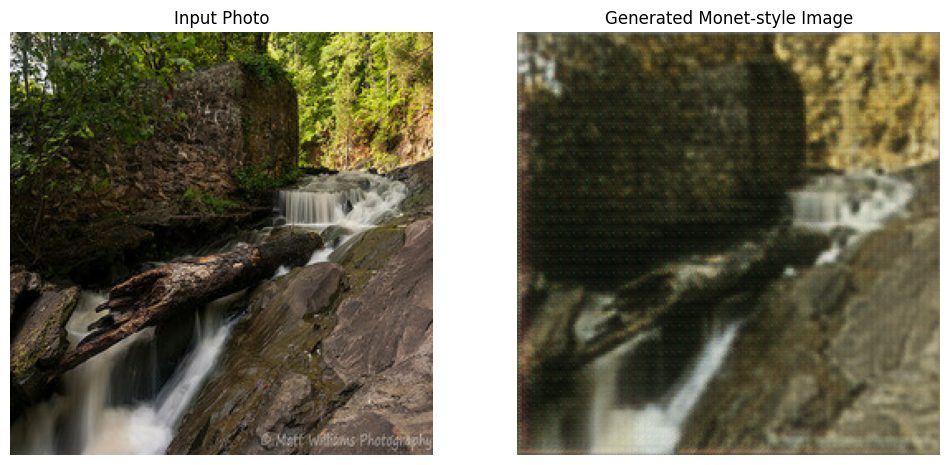

Epoch 2/2


  0%|          | 0/300 [00:00<?, ?it/s]

  Batch 0/300
  Batch 50/300
  Batch 100/300
  Batch 150/300
  Batch 200/300
  Batch 250/300
Time taken for epoch 2: 1392.26 sec


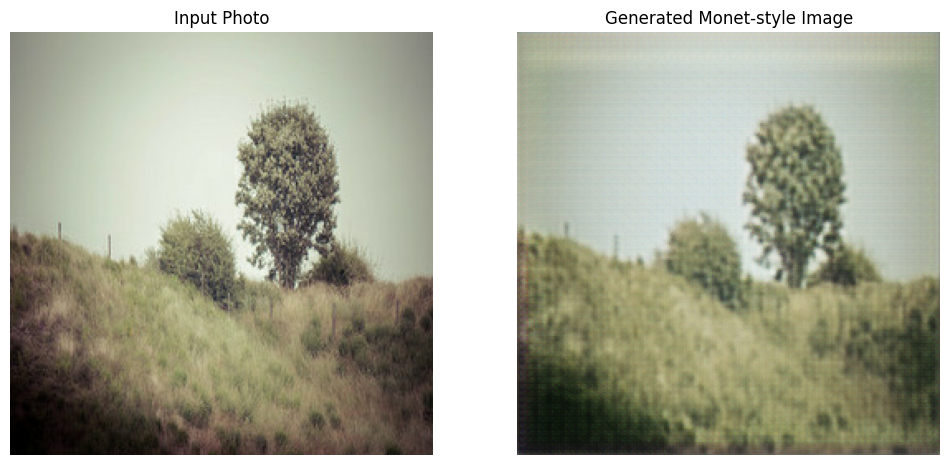

In [14]:
# Execute the training (uncomment to run)
# Note: Training GANs can take a long time, especially without a GPU
# For demonstration purposes, we'll train for just 2 epochs
# In a real scenario, you would train for more epochs (e.g., 10-50)

train(monet_dataset, photo_dataset, epochs=2)

## 7. Generate Images

Let's test our trained generator with a sample image.

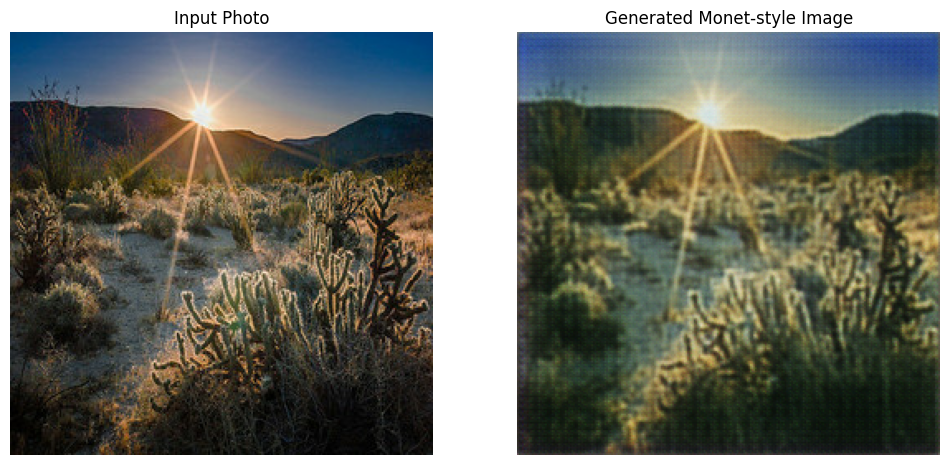

In [15]:
# Test the generator with a sample image
if photo_dataset is not None:
    for sample_photo in photo_dataset.take(1):
        generate_images(generator_g, sample_photo)
        break

## 8. Conclusion

In this notebook, we've trained the CycleGAN architecture for generating Monet-style images from photographs. The key components include:

1. **Loading Pre-trained Models**: We loaded the generator and discriminator models that were defined in the previous notebook.
2. **Training Process**: We set up and executed the training process with optimizers, a training step function, and a training loop.
3. **Image Generation**: We used the trained generator to transform photographs into Monet-style paintings.

In the next notebook, we'll evaluate the model's performance and prepare our submission for the Kaggle competition.